In [1]:
import pandas as pd
pd.set_option("display.width", 380)
pd.set_option('max_colwidth', 200)

from langdetect import detect

from IPython.display import display

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#To handle warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("./dataLemmatized.csv", sep=',')

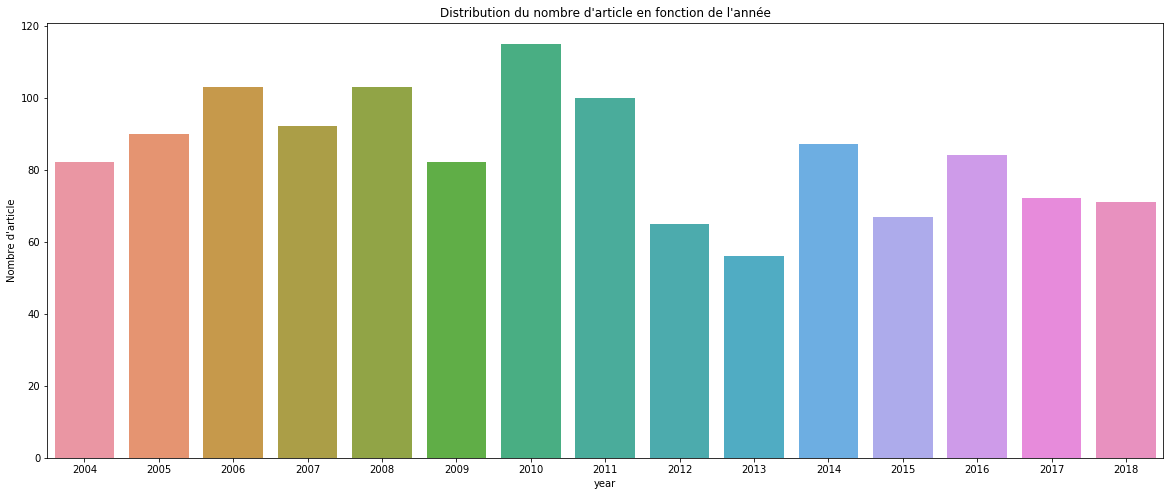

1269 articles


In [3]:
invYr = df.groupby(['year']).count()
sns.barplot(x=invYr.index, y=invYr.series)
plt.title("Distribution du nombre d'article en fonction de l'année")
plt.ylabel("Nombre d'article")
fig=plt.gcf()
fig.set_size_inches(20,8)
plt.show()
print("%d articles" % len(df))

In [4]:
df['lng_title'] = df['title'].apply( lambda x : detect(x))
df['lng_abstract'] = df['abstract'].apply( lambda x : detect(x) if x is not pd.np.nan else pd.np.nan)

In [5]:
display(df[['title', 'abstract', 'lng_title', 'lng_abstract']].head(10))
print("French  title: {}\nEnglish title {}\n\nFrench  abstract {}\nEnglish abstract {}".format(
   len(df[df['lng_title'] == 'fr']), 
   len(df[df['lng_title'] == 'en']) ,
   len(df[df['lng_abstract'] == 'fr']) ,
   len(df[df['lng_abstract'] == 'en'])))


,title,abstract,lng_title,lng_abstract
0,#Idéo2017 : une plateforme citoyenne dédiée à l'analyse des tweets lors des événements politiques,"Cette plateforme a pour objectif de permettre aux citoyens d'analyserpar eux-mêmes les tweets politiques lors d'événements spécifiques en France.Pour le cas de l'élection présidentielle de 2017, #...",fr,fr
1,A two level co-clustering algorithm for very large data sets,La classification croisée (co-clustering) est une technique qui permet d'extraire la structuresous-jacente existante entre les lignes et les colonnes d'une table de données sous forme de blocs. Pl...,en,fr
2,ALGeoSPF: Un modèle de factorisation basé sur du clustering géographique pour la recommandation de POI,La recommandation de points d'intérêts est devenue une caractéristiqueessentielle des réseaux sociaux géo-localisés qui a accompagnél'émergence des échanges massifs de données digitales. Cependant...,fr,fr
3,Analyse des sentiments à partir des commentaires Facebook publiés en Arabe standard ou dialectal marocain par une approche d'apprentissage automatique,"L'analyse des sentiments est un processus pendant lequel la polarité(positive, négative ou neutre) d'un texte donné est déterminée. Nous nous intéressonsdans ce travail à l'analyse des sentiments ...",fr,fr
4,Analyse en rôles sémantiques pour le résumé automatique,Cet article présente une approche visant à extraire les informations expriméesdans un corpus de textes et en produire un résumé. Plusieurs variantes deméthodes extractives de résumé de texte ont é...,fr,fr
5,Analyse Ontologique de scénario dans un contexte Big Data,NaN,fr,NaN
6,Apport de la fouille de données pour la prévention du risque suicidaire,"Avec plus de 800 000 décès par an dans le monde, le suicide est latroisième cause de décès évitable. Il y a 20 fois plus de tentatives, impliquant denombreuses hospitalisations, des coûts humains ...",fr,fr
7,Apport des modèles locaux pour les K-moyennes prédictives,"Dans le cadre du clustering prédictif, pour attribuer la classe aux groupesformés à la fin de la phase d'apprentissage, le vote majoritaire est la méthodecommunément utilisée. Cependant, cette app...",fr,fr
8,Apprendre les relations de préférence et de co-occurrence entre les labels en classification multi-labels,"En classification multi-labels, chaque instance est associée àun ou plusieurs labels. Par exemple, un morceau de musique peut êtreassocié aux labels 'heureux' et 'relaxant'. Des relations de co-oc...",fr,fr
9,Approche contextuelle par régression pour les tests A/B,"Les tests A/B sont des procédures utilisées par les entreprises du webet de la santé entre autres, pour mesurer l'impact d'un changement de versiond'une variable par rapport à un objectif. Bien qu...",fr,fr


French  title: 1134
English title 122

French  abstract 991
English abstract 105


In [6]:
# For French
df_fr_title = df[df['lng_title'] == 'fr']
df_fr_abstract = df[df['lng_abstract'] == 'fr']

# Do the French Lem and Prepros
df['lem_prepro_title'] = df['titleLemma']
df['lem_prepro_abstract'] =  df['abstractLemma']

# Display the result
display(df[['lng_title', 'lng_abstract' ,'lem_prepro_title' ,'lem_prepro_abstract']].head())

,lng_title,lng_abstract,lem_prepro_title,lem_prepro_abstract
0,fr,fr,plateforme citoyen dédiée analyser tweets événement politiques,plateforme objectif permettre citoyen analyserpar même tweets politiques événement spécifiques france élection présidentielle analyser quasitemps message candidat fournir principal caractéristique...
1,en,fr,algorithme clustering niveau grand ensemble donnée,classification croisée clustering technique permettre extraire structuresous jacente existante entre ligne colonne tabler donnée forme bloc plusieurs application utiliser technique cependant nombr...
2,fr,fr,algeospf modèle factorisation clustering géographique recommandation,recommandation point intérêt devenir caractéristiqueessentielle réseau sociaux localiser accompagnél émergence échange massif donnée digitale cependantles faible densités point intérêt visiter uti...
3,fr,fr,analyser sentiment partir commentaire facebook publier arabe standard dialectal marocain approche apprentissage automatique,analyser sentiment processus pendant lequel polarité positive négative neutre texte donner déterminée intéressonsdans travail analyser sentiment partir commentairesfacebook réel partager arabe sta...
4,fr,fr,analyser rôle sémantique résumer automatique,article présente approcher viser extraire information expriméesdans corpus texte produire résumer plusieurs variante deméthodes extractives résumer texte implémenter évaluer leurprincipale origina...


In [7]:
# with ou without the abstract
def join_with_nan(subset_df):
    res = []
    if subset_df['lem_prepro_title'] is not pd.np.nan:
        res += subset_df['lem_prepro_title'].split()
    # if subset_df['lem_prepro_abstract'] is not pd.np.nan:
        # res += subset_df['lem_prepro_abstract'].split()
    return res

# Join the lematized title and abstract
df_all_lem = df.apply(join_with_nan, axis=1)
display(df_all_lem.head())


0                                                                       [plateforme, citoyen, dédiée, analyser, tweets, événement, politiques]
1                                                                                    [algorithme, clustering, niveau, grand, ensemble, donnée]
2                                                                  [algeospf, modèle, factorisation, clustering, géographique, recommandation]
3    [analyser, sentiment, partir, commentaire, facebook, publier, arabe, standard, dialectal, marocain, approche, apprentissage, automatique]
4                                                                                           [analyser, rôle, sémantique, résumer, automatique]
dtype: object

In [8]:
import gensim

# Create Dictionary
id2word = gensim.corpora.Dictionary(df_all_lem)

count = 0
for k, v in id2word.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 analyser
1 citoyen
2 dédiée
3 plateforme
4 politiques
5 tweets
6 événement
7 algorithme
8 clustering
9 donnée
10 ensemble


In [9]:
# Custom Stop words
custom_stop_words = ['algorithme', 'étude', 'méthode', 'approche', 'nouvelle', 'algorithme', 'automatique', 'système'
                    'source', 'exemple', 'concevoir', 'ensuite', 'définir', 'effectuer']
df_all_lem = df_all_lem.apply(lambda word_list: [word for word in word_list if word not in custom_stop_words])
""


''

In [31]:
# Filter out tokens that appear in 
id2word.filter_extremes(no_below=15,   # - less than X documents (absolute number)
                        no_above=0.10, # - more than X documents (fraction of total corpus size, not absolute number)
                        keep_n=10000)  # - after the above two steps, keep only the first X most frequent tokens.

bow_corpus = [id2word.doc2bow(doc) for doc in df_all_lem]

In [11]:
bow_doc = bow_corpus[0]

# Pandas df
display(", ".join(df_all_lem[0]))

# bow representation
for i in range(len(bow_doc)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc[i][0],
                                               id2word[bow_doc[i][0]],
                                               bow_doc[i][1]))

'plateforme, citoyen, dédiée, analyser, tweets, événement, politiques'

Word 0 ("analyser") appears 1 time.


In [12]:
tfidf = gensim.models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
for doc in corpus_tfidf:
    display(doc)
    break

[(0, 1.0)]

In [13]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=200, id2word=id2word, passes=2, workers=4)

In [14]:
for idx, topic in lda_model.print_topics(-1)[:5]:
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.240*"gestion" + 0.240*"connaissance" + 0.120*"système" + 0.076*"graphe" + 0.047*"base" + 0.047*"recherche" + 0.047*"recommandation" + 0.047*"apprentissage" + 0.047*"baser" + 0.047*"comparaison"
Topic: 1 
Words: 0.192*"prédiction" + 0.155*"baser" + 0.155*"construction" + 0.133*"motif" + 0.096*"apprentissage" + 0.096*"séquentiels" + 0.061*"domaine" + 0.037*"comparaison" + 0.037*"analyser" + 0.000*"système"
Topic: 2 
Words: 0.468*"supervisée" + 0.392*"classification" + 0.117*"image" + 0.011*"multi" + 0.000*"sélection" + 0.000*"outil" + 0.000*"modélisation" + 0.000*"méthode" + 0.000*"recherche" + 0.000*"objet"
Topic: 3 
Words: 0.176*"motif" + 0.088*"temporelles" + 0.088*"visualisation" + 0.088*"découverte" + 0.088*"fréquents" + 0.088*"arbre" + 0.088*"image" + 0.088*"série" + 0.088*"entre" + 0.088*"approcher"
Topic: 4 
Words: 0.185*"clustering" + 0.128*"sémantique" + 0.128*"réseau" + 0.128*"système" + 0.092*"supervisé" + 0.092*"visuel" + 0.071*"gestion" + 0.036*"annotatio

In [15]:
#For visualising LDA Output
import pyLDAvis.gensim
from metakernel.display import display

lda_display = pyLDAvis.gensim.prepare(lda_model, bow_corpus, id2word, sort_topics=False)
pyLDAvis.display(lda_display)

In [44]:
# https://github.com/Riti-Chakraborty/Dissertation-Project/blob/a0860fd676c417ce7d1874815f94e97a183395c5/Project_Kmeans1.ipynb
# https://github.com/kinimod23/ANLP_Final_Project/blob/2cee63dbf21516f5a3dd8215f8f63a696d28cf2f/All_scripts.ipynb
def apply_lda(bow_corpus, lda_trained):
    return [lda_trained[article] for article in bow_corpus]

corpus_feature_vectors = apply_lda(bow_corpus, lda_model)

In [17]:
def create_lda_output(corpus_feature_vectors):
    output = []
    for vec in corpus_feature_vectors:
        vec_dic = dict(vec)
        output.append([(vec_dic[topic] if topic in vec_dic else 0) for topic in range(10)])
    return output

output = create_lda_output(corpus_feature_vectors)

In [29]:
# BIG Dump :poop:
if False:
    lda_model.save('LDA_model.gensim')
    id2word.save('dictionary.gensim')
    import pickle
    pickle.dump(bow_corpus, open('corpus.pkl', 'wb'))